# Therapeutic Inertia Nano Sim Test

This notebook is designed to be a nanosim testing different therapeutic inertia parameters in order to see what might be the most effective for use in the CVD sim. 

To build off of that - we are adding the discontinuation piece.

In [1]:
import pandas as pd, numpy as np, os
import scipy.stats, random, matplotlib.pyplot as plt 
import math

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from vivarium import InteractiveContext, Artifact
from pathlib import Path

## Data Loading / Creation

In [3]:
inertia = 0.20 ## Means 20% of people DO GET treated and/or tirated on any time step
## Could be easier to change the cutoff instead of the sim level component 

medication_rate = 0.4
nhanes_medication_rate = 0.597492 # Approx 60% of people who should be on meds are on meds 
sim_prop_rate = 0.5 #Means 50% of the propensity is due to the sim and 50% is random 
churn_rate = 0.02 #Adding a "churn" which is meant to represent people dying + new people needing SBP meds (aging in basically) 
base_discontinuation = 0.314

In [4]:
med_rr = medication_rate / nhanes_medication_rate
med_rr

0.6694650304941322

In [5]:
time_step_discon = base_discontinuation/12 / med_rr
time_step_discon

0.039085934999999995

In [6]:
adjusted_discon = base_discontinuation / med_rr
adjusted_discon

0.46903121999999997

Notes on churn rate: 

We need to include a churn in the model, otherwise with any random component the medication rate will only stabilize at 100%, which we don't want. However, the churn parameter is difficult to conceptualize and quantify. Therefore we completed some sensitivity testing and found that a churn rate between 1-10% gave reasonable results in the nanosim. We think that churn in the full model will fall in this range. 

<Axes: >

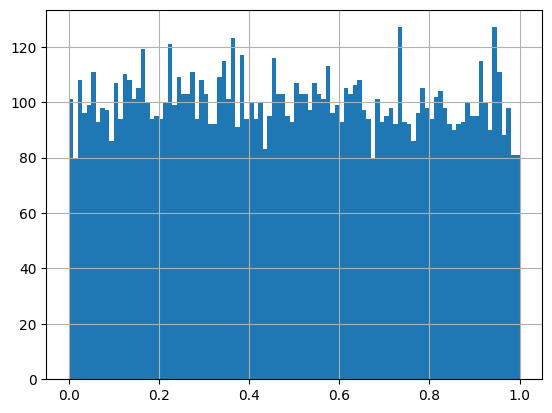

In [3]:
pop = 10_000
sims = pd.DataFrame()
sims['sim_propensity'] = np.random.normal(0, math.sqrt(sim_prop_rate), pop) 
sims['random_propensity'] = np.random.normal(0, math.sqrt(1-sim_prop_rate), pop) 
sims['total_propensity'] = scipy.stats.norm.cdf(sims['sim_propensity'] + sims['random_propensity'])
sims['total_propensity'].hist(bins=100)
##Looking like this works! 

In [4]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')
sim = InteractiveContext(path, setup=False)

In [5]:
sim.configuration.update({
                      'population':
                          {'population_size': 10_000,
                          },
                      }
                    )
sim.setup()

2023-12-06 10:50:11.586 | INFO     | simulation_1-artifact_manager:67 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/artifacts/51-locations/v3-20231019/alabama.hdf.
2023-12-06 10:50:11.588 | INFO     | simulation_1-artifact_manager:68 - Artifact base filter terms are ['draw == 0'].
2023-12-06 10:50:11.590 | INFO     | simulation_1-artifact_manager:69 - Artifact additional filter terms are None.


In [6]:
pop0 = sim.get_population()

In [7]:
data1 = pd.concat([pop0,
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                  ], axis=1)
data1 = data1.loc[(data1.alive == 'alive') & (data1.age > 25)].reset_index()

In [8]:
data1['sbp_medication_new'] = np.where(data1['sbp_medication'] == 'one_drug_half_dose_efficacy', 1, 
                                      np.where(data1['sbp_medication'] == 'two_drug_half_dose_efficacy', 3, 0))

## The Nanosim

In [64]:
def run_nanosim(pop, n_steps):
    final_data = pd.DataFrame()
    final_data['time_step'] = range(n_steps)
    final_data['percent_meds_1'] = range(n_steps)
    final_data['percent_meds_2'] = range(n_steps)
    final_data['percent_meds_3'] = range(n_steps)
    final_data['percent_meds_4'] = range(n_steps)
    final_data['percent_meds_5'] = range(n_steps)
    final_data['percent_meds_6'] = range(n_steps)
    final_data['percent_meds_all'] = range(n_steps)
    
    sims = pd.DataFrame()
    sims['ID'] = range(pop)
    sims['meds'] = data1['sbp_medication_new']

    sims['start_med_time_step'] = np.where(sims['meds'] != 0, int(random.uniform(0, 36)), 9999)

    sim_meds = sims.loc[sims['meds'] == 0]
    prev_discon = np.random.choice(len(sim_meds), int(adjusted_discon*len(sim_meds)), replace = False)
    sims.iloc[prev_discon, sims.columns.get_loc('start_med_time_step')] = 8888    
    
    ### 9999 indicates that you are not on meds but can start 
    ### 8888 indicates that you have previously discontinued meds 
    sims['sim_propensity'] = np.random.normal(0, math.sqrt(sim_prop_rate), pop) 
    ##Should really change this to the raw value 
    sims['original_sbp'] =  data1['high_sbp']
    sims['adjusted_sbp'] =  data1['high_sbp']

    for i in range(n_steps):
        sims['time_step'] = i
        sims['random_propensity'] = np.random.normal(0, math.sqrt(1-sim_prop_rate), pop) 
        sims['total_propensity'] = scipy.stats.norm.cdf(sims['sim_propensity'] + sims['random_propensity'])

        #Reset some people to no meds due to churn
        chosen_idx = np.random.choice(pop, int(churn_rate*pop), replace = False)
        sims.iloc[chosen_idx, sims.columns.get_loc('meds')] = 0
        sims.iloc[chosen_idx, sims.columns.get_loc('start_med_time_step')] = 9999
        
        #Put people on medication or up their medication 
        sims['meds'] = np.where(sims['meds'] == 6, 6, 
                                np.where(sims['start_med_time_step'] == 8888, 0, 
                                np.where(sims['adjusted_sbp'] < 130, sims['meds'], 
                                np.where(sims['total_propensity'] < inertia, sims['meds'] + 1, sims['meds']))))

        ##Lower SBP levels as a result of medication. 
        ##Each additional SBP med level is assumed to decrease SBP by 5 points. This is an oversimplifcation but works on average. 
        sims['adjusted_sbp'] = sims['original_sbp'] - (5*sims['meds'])
        
        ##Discontinue some people based on state 
        ###First record the first time people are on meds 
        sims['start_med_time_step'] = np.where(sims['meds'] != 1, sims['start_med_time_step'], 
                                             np.where(sims['start_med_time_step'] == 9999, i, sims['start_med_time_step']))

        ##Need to discontinue 1/3 ish of people who have been on meds less than 1 year 
        discon_eligible = sims.loc[(sims['start_med_time_step'] > (i - 13)) & (sims['start_med_time_step'] != 9999)]
        discontinue_chosen_idx = np.random.choice(len(discon_eligible), int(time_step_discon*len(discon_eligible)), replace = False)
        sims.iloc[discontinue_chosen_idx, sims.columns.get_loc('meds')] = 0
        ###And make them ineligible for meds 
        sims.iloc[discontinue_chosen_idx, sims.columns.get_loc('start_med_time_step')] = 8888
        
        #Get percent medicated for each time step 
        final_data.iloc[i,1] = len(sims.loc[sims['meds'] == 1])/len(sims.loc[sims['original_sbp'] > 130])
        final_data.iloc[i,2] = len(sims.loc[sims['meds'] == 2])/len(sims.loc[sims['original_sbp'] > 130])
        final_data.iloc[i,3] = len(sims.loc[sims['meds'] == 3])/len(sims.loc[sims['original_sbp'] > 130])
        final_data.iloc[i,4] = len(sims.loc[sims['meds'] == 4])/len(sims.loc[sims['original_sbp'] > 130])
        final_data.iloc[i,5] = len(sims.loc[sims['meds'] == 5])/len(sims.loc[sims['original_sbp'] > 130])
        final_data.iloc[i,6] = len(sims.loc[sims['meds'] == 6])/len(sims.loc[sims['original_sbp'] > 130])
        final_data.iloc[i,7] = len(sims.loc[sims['meds'] != 0])/len(sims.loc[sims['original_sbp'] > 130])
        
    return final_data

In [71]:
test = run_nanosim(1_000, 200)
#test

Text(0.5, 1.0, 'No Meds for Target Med Rate 0.4 with RR 1.49373')

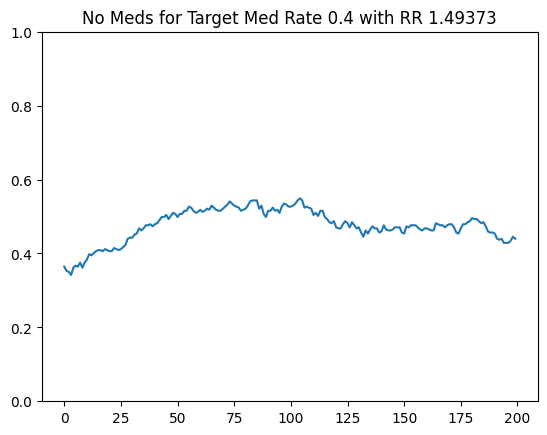

In [72]:
test['no_meds'] = 1 - test.percent_meds_all
plt.plot(test.time_step, test.no_meds)
plt.ylim(0,1)
plt.title(f'No Meds for Target Med Rate {medication_rate} with RR {med_rr}')